## Import Libraries

In [1]:

import gc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import tensorflow as tf
import seaborn
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib as mpl
import numpy as np
import itertools
import logging
# Set random seed
np.random.seed(123)

## Grad-CAM ++ Function

##### Output signal : The output will be the signal with each important segment draw with a color which represent the importance for the classification/prediction

In [2]:
def multicolored_lines(x,y,heatmap,title_name):
    fig, ax = plt.subplots()
    lc = colorline(x, y, heatmap,cmap='rainbow')
    plt.colorbar(lc)
    lc.set_linewidth(2)
    lc.set_alpha(0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.title(title_name)
    plt.grid(False)
    plt.show()

def colorline(x, y, heatmap,cmap='rainbow'):
    z = np.array(heatmap)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc


In [3]:
def compute_cam_1d_output (model, data , layer_name , N):
        """
        model: The Deep Learning model
        data : A input data. Data shape has to be (n,1,1)
        layer_name : The target layer for explanation
        N: signal length in seconds
        """
        # input layer, model output layer and target layer
        grad_model = tf.keras.models.Model(inputs=[model.inputs],outputs=[model.get_layer(layer_name).output, model.output])     
        
        # Getting gradients of input layer, model output layer (predictions) and target layer
        with tf.GradientTape() as tape:
            inputs = np.expand_dims(data,axis=0)
            conv_outs, predictions = grad_model(inputs) 
            class_idx = tf.argmax(predictions[0])
            y_c = predictions[:, class_idx]

        batch_grads = tape.gradient(y_c, conv_outs) 
        grads = batch_grads[0]
        
        # First, second and third derivative of output gradient
        first = tf.exp(y_c) * grads
        second = tf.exp(y_c) * tf.pow(grads, 2)
        third = tf.exp(y_c) * tf.pow(grads, 3)
        
        # Compute salienty maps for the class_idx prediction
        global_sum = tf.reduce_sum(tf.reshape(conv_outs[0], shape=(-1, first.shape[1])), axis=0)
        alpha_num = second
        alpha_denom = second * 2.0 + third * tf.reshape(global_sum, shape=(1,1,first.shape[1]))
        alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones(shape=alpha_denom.shape))
        alphas = alpha_num / alpha_denom
        weights = tf.maximum(first, 0.0)
        alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas, axis=0), axis=0)
        alphas /= tf.reshape(alpha_normalization_constant, shape=(1,1,first.shape[1]))
        alphas_thresholding = np.where(weights, alphas, 0.0)

        alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas_thresholding, axis=0),axis=0)
        alpha_normalization_constant_processed = tf.where(alpha_normalization_constant != 0.0, alpha_normalization_constant,
                                                          tf.ones(alpha_normalization_constant.shape))

        alphas /= tf.reshape(alpha_normalization_constant_processed, shape=(1,1,first.shape[1]))
        deep_linearization_weights = tf.reduce_sum(tf.reshape((weights*alphas), shape=(-1,first.shape[1])), axis=0)
        grad_CAM_map = tf.reduce_sum(deep_linearization_weights * conv_outs[0], axis=-1)
        
        # Normalization
        cam = np.maximum(grad_CAM_map, 0)
        cam = cam / np.max(cam)  
        
        # Turn result into a heatmap
        heatmap=[]
        heatmap.append(cam.tolist())
        big_heatmap = cv2.resize(np.array(heatmap), dsize=(data.shape[0], 500),interpolation=cv2.INTER_CUBIC)
        x = np.linspace(0, N, data.shape[0])
        plt.style.use("seaborn-whitegrid")
        multicolored_lines(x,np.array([i[0] for i in data]),big_heatmap[0],f"GradCAM ++ Visualization")

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support

In [5]:
#read the pickle files
not_aug_df=pd.read_pickle('EMOVO_dataset/not_aug_df.pkl')
semi_aug_df=pd.read_pickle('EMOVO_dataset/semi_aug_df.pkl')
aug_df=pd.read_pickle('EMOVO_dataset/aug_df.pkl')

scaler = StandardScaler()

#creation of the array containg the emotions ordered by their encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
sorted_labels=[]
label_encoder.fit(not_aug_df['label'])
name_mapping = dict(zip( label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
for i in range(7):
  sorted_labels.append(name_mapping[i])
sorted_labels


['anger', 'disgust', 'fear', 'joy', 'neutrality', 'sadness', 'surprise']

In [10]:
scaler = StandardScaler()
#extraction of the mfccs from the datasets - not aug
X_mfccs_k = np.array(not_aug_df.iloc[:, 3:29])
X_mfccs_k=np.array(X_mfccs_k.tolist())
X_mfccs_k=scaler.fit_transform(X_mfccs_k.reshape(-1, X_mfccs_k.shape[-1])).reshape(X_mfccs_k.shape)
Y_mfccs_k=not_aug_df['label']


#extraction of the log mel specrogram from the datasets - not aug
X_logmel_k = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k=np.array(X_logmel_k.tolist())
X_logmel_k=scaler.fit_transform(X_logmel_k.reshape(-1, X_logmel_k.shape[-1])).reshape(X_logmel_k.shape)
Y_logmel_k=not_aug_df['label']

#reshape the data from 3D to 2D - not aug
X_mfccs_k=X_mfccs_k.reshape(X_mfccs_k.shape[0],X_mfccs_k.shape[1]*X_mfccs_k.shape[2])
X_logmel_k=X_logmel_k.reshape(X_logmel_k.shape[0],X_logmel_k.shape[1]*X_logmel_k.shape[2])

X_logmel_k = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])


In [11]:
#extraction of labels_id from datasets
Y_not_aug=not_aug_df['label_id']
Y_semi_aug=semi_aug_df['label_id']
Y_aug=aug_df['label_id']


#take the log mel spectrogram from the datasets
X_logmel = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel=np.array(X_logmel.tolist())
X_logmel_semi_aug = np.array(semi_aug_df.loc[:, ['logmel' in i for i in semi_aug_df.columns]])
X_logmel_semi_aug=np.array(X_logmel_semi_aug.tolist())
X_logmel_aug = np.array(aug_df.loc[:, ['logmel' in i for i in aug_df.columns]])
X_logmel_aug=np.array(X_logmel_aug.tolist())


#take the mfccs & deltas from the datasets
X_mfccs = np.array(not_aug_df.iloc[:, 3:29]) 
X_mfccs=np.array(X_mfccs.tolist())
X_mfccs_semi_aug = np.array(semi_aug_df.iloc[:, 3:29])
X_mfccs_semi_aug=np.array(X_mfccs_semi_aug.tolist())
X_mfccs_aug = np.array(aug_df.iloc[:, 3:29])
X_mfccs_aug=np.array(X_mfccs_aug.tolist())

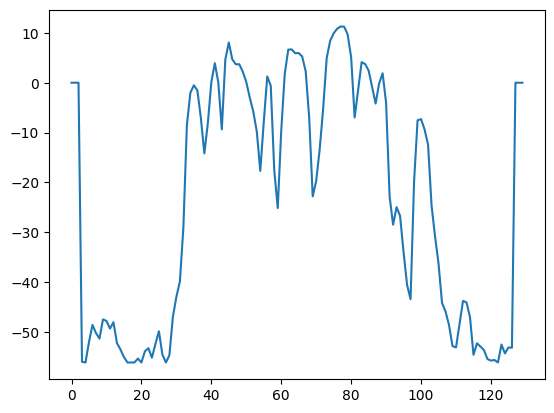

In [19]:
plt.plot(X_logmel_aug[0][3])

In [ ]:
from gradcam import GradCAM


general_reports_dir_gradcam =  os.path.join(general_reports_dir_current, 'gradcam')
os.makedirs(general_reports_dir_gradcam)

gCAM = gradcam.GradCAM(model)
gCAM.make_models()

heatmap_original, crash_probability_original = gCAM.run_gradcam(
    acc=X_acc,
    vel=X_pos,
    repeats=True,
    relu=False,
    normalize=False,
    class_to_explain=class_to_explain
)

heatmap_perturbed_tilde = np.ones(X_acc[0].shape)
gradcam_heatmap = np.ones(X_acc[0].shape)
for ax, heatmap_name in zip(np.arange(3), ['x_axis', 'y_axis', 'z_axis']):
    # Perturb multivariate series.
    acc_gradcam = gCAM.perturb_time_series(X_acc, axis_to_explain=ax)

    # Run GradCAM on perturbed multivariate series.
    heatmap_perturbed_tilde[:, ax], crash_probability_perturbed = gCAM.run_gradcam(
        acc=acc_gradcam,
        vel=X_pos,
        repeats=True,
        relu=False,
        normalize=True,
        class_to_explain=class_to_explain
    )

    gradcam_heatmap[:, ax] = gCAM.ricombination_method(
        heatmap_original,
        crash_probability_original,
        heatmap_perturbed_tilde[:, ax],
        crash_probability_perturbed
    )

    if cfg['reports']['snap']:
        util_report.plot_acc(outdir=general_reports_dir_gradcam, acc=acc_gradcam, info=f'mts_{heatmap_name}')
        util_report.plot_mts_heatmap(outdir=general_reports_dir_gradcam, acc=acc_gradcam, heatmap=heatmap_perturbed_tilde[:, ax], info=f'mts_heatmap_{heatmap_name}')

util_report.plot_heatmap(outdir=general_reports_dir_gradcam, acc=X_acc, heatmap=gradcam_heatmap, info=f'gradcam')

In [4]:
import tensorflow as tf

In [3]:
modelcnn = tf.keras.models.load_model('ser_aug_25_09_2024_11_06_25.keras')

NameError: name 'tf' is not defined